## 2.4　Newtonブースティング法の`lightgbm`によるデモ

### A. Newtonブースティング決定木回帰モデル

ここでは、Newtonブースティング決定木回帰モデルの`lightgbm` packageによるデモを行います。勾配ブースティング決定木回帰モデルは次のようなalgorithmのことです:

**Input** :
* $\eta>0$ : 学習率
* $\nabla_h L$ : 目的関数$L$の1階導関数
* $\nabla^2_h L$ : 目的関数$L$の2階導関数
* $M$ : 繰り返しの最大回数

**Process** :
1. $\hat{h}(x)\leftarrow \bar{y}$
2. for $t$ in $1,\cdots,M$:
3. 　　$h_{t}$を$\nabla_h L$, $\nabla^2_h L$が定める決定木の学習アルゴリズムで求める。
4. 　　$\hat{h}(x)\leftarrow\hat{h}(x)+\eta h_{t}(x)$
5. return $\hat{h}(x)$

`lightgbm` moduleには勾配ブースティング決定木回帰モデルの実装である`GradientBoostingRegressor` classがあります。引数としてhyperparameterである
* `learning_rate` : 学習率
* `n_estimators` : 繰り返しの最大数
* その他、決定木回帰モデルのhyperparameter
    - `num_leaves` : 葉ノードの最大数
    - `min_child_samples` : 葉ノードに所属する訓練データ点のサイズの最小値

を指定することが出来ます。

### B. 荻窪ワンルームマンションの予測

#### B1. データの説明と読み込み

これは荻窪のワンルームマンションの物件に関する情報を収集してきた実データです。次のような変数をレコードしてきました。
* name : 物件名
* value : 家賃[万円]
* area : 面積[m²]
* age : 築年数[年]（注 : 新築の場合0年）
* distance : 最寄り駅（JR中央線荻窪駅）まで徒歩でかかる時間[分]
* bath_toilet_separated : バス・トイレ別（1 : True, 0 : False）
* autolock : オートロック（1 : True, 0 : False ）

今回は「荻窪のワンルームマンションの家賃を他の物件情報を用いて予測できるようにしよう」というタスクに勾配ブースティング決定木回帰で挑戦してみたいと思います。

In [6]:
# データの読み込み
import pandas as pd
filepath_train = ".\data\ogikubo_oneroom_train.csv"
oneroom_train = pd.read_csv(filepath_or_buffer = filepath_train)
oneroom_train.head(n = 5)

,name,value,area,age,distance,bath_toilet_separated,autolock
0,フェリーチェ上井草A,6.0,15.12,0,15,1,1
1,メゾン・ド・荻窪,4.5,12.11,40,7,0,0
2,ＪＲ中央線 荻窪駅 3階建 築40年,4.5,12.11,40,6,0,0
3,フェリーチェ上井草A,6.3,15.12,0,15,1,1
4,グローリア初穂阿佐ヶ谷,6.0,16.65,31,15,0,1


#### B2. 特徴量選択

今回は、すべての入力変数`area`, `age`, `distance`, `bath_toilet_separated`, `autolock`を用いて、出力変数`value`を予測していきます。

In [7]:
# 特徴量の選択とデータの準備
feature_name = ["area", "age", "distance", "bath_toilet_separated", "autolock"]
X_train = oneroom_train[feature_name].values
y_train = oneroom_train["value"].values

また、early stoppingを行うために、訓練データを事前に学習用と検証用に分割します。

In [8]:
# early stopping
from sklearn.model_selection import train_test_split
X_learn, X_val, y_learn, y_val = train_test_split(X_train, y_train, test_size = 0.2)

#### B3. モデルの学習

Newtonブースティング決定木回帰のインスタンスを建てて学習を行います。学習は`fit` methodに入力変数の配列`X_train`と出力変数の配列`y_train`を渡すことで計算できます。また、`fit` methodはearly stoppingのための
* `eval_set` : 検証用データセットを渡す引数
* `early_stopping_rounds` : 1時点前から`early_stopping_roundes`時点前のすべてに対して、検証データにおける損失が現在よりも小さい場合、学習を打ち止める。

という2つの引数を持ちます。

In [9]:
# 勾配ブースティング決定木回帰モデルの学習
from lightgbm import LGBMRegressor
nbr = LGBMRegressor(learning_rate = 0.01,
                    n_estimators = 1000,
                    num_leaves = 4,
                    min_child_samples = 10)
nbr.fit(X_learn, y_learn,
        eval_set = (X_val, y_val), 
        early_stopping_rounds = 5, 
        verbose = 50)     # verboseは学習の様子をprintするiterationの間隔

Training until validation scores don't improve for 5 rounds
[50]	valid_0's l2: 3.27433
[100]	valid_0's l2: 1.89064
[150]	valid_0's l2: 1.30133
[200]	valid_0's l2: 0.993689
[250]	valid_0's l2: 0.830741
[300]	valid_0's l2: 0.75585
[350]	valid_0's l2: 0.717267
Early stopping, best iteration is:
[359]	valid_0's l2: 0.713939


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=-1,
              min_child_samples=10, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=4, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

`[50] valid_0's l2: 2.69296`は`eval_set`に指定した検証用データ (<u>valid</u>ation data) で、<u>50</u>回目のiteration時に学習器の2乗損失(<u>l2</u> loss)が<u>2.69296</u>であったという意味を表しています。

#### B4. 予測とモデル評価

学習したモデルによる予測は`predict` methodに予測したいデータポイントの入力配列を渡すことで計算できます。このmethodを用いて、
* 訓練データとテストデータにおける残差プロット
* 訓練データとテストデータにおける決定係数

を描いてみましょう。テストデータを読み込んでおきます。

In [10]:
# テストデータの読み込み
filepath_test = ".\data\ogikubo_oneroom_test.csv"
oneroom_test = pd.read_csv(filepath_or_buffer = filepath_test)
X_test = oneroom_test[feature_name].values
y_test = oneroom_test["value"].values

また、訓練データ・テストデータに対する予測値を計算しておきます。

In [11]:
pred_train, pred_test = nbr.predict(X_train), nbr.predict(X_test)

**残差プロット** : 横軸を予測値・縦軸を残差にとった散布図を描きます。

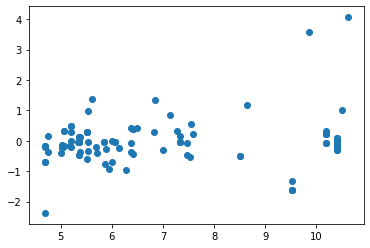

In [12]:
# 訓練データの残差プロット
import matplotlib.pyplot as plt
error_train = y_train - pred_train
plt.scatter(pred_train, error_train)
plt.show()

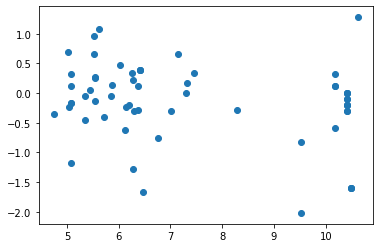

In [13]:
# テストデータの残差プロット
import matplotlib.pyplot as plt
error_test = y_test - pred_test
plt.scatter(pred_test, error_test)
plt.show()

**決定係数** : 訓練データとテストデータにおける決定係数を計算しておきます。

In [14]:
# 決定係数によるモデルの評価（訓練データ）
from sklearn.metrics import r2_score
r2_score(y_true = y_train, y_pred = pred_train)

0.8784625217344164

In [15]:
# 決定係数によるモデルの評価（テストデータ）
from sklearn.metrics import r2_score
r2_score(y_true = y_test, y_pred = pred_test)

0.8942049293420256

### C. 変数重要度

Newtonブースティング決定木回帰モデルもまた決定木の他のアンサンブル学習と同様にして**変数重要度** (feature importance) を計算することが出来ます。各iterationで学習した決定木回帰の変数重要度について、入力変数ごとに平均をとったものを変数重要度と定義します。なお、`lightGBM` packageは`sklearn`の勾配ブースティング決定木回帰と異なり、変数重要度の合計を1にする正規化は行わずに出力されますが、これと意味は同じです。

[Remark] 変数重要度の定義には複数あり、変数重要度の高い順番に入力変数を並べても結果が異なり得るなどの違いを持っています。例えば`feature_impotances_`変数は、決定木のノードにその変数が現れた数を変数重要度として返す方法を採用しています。以下のスクリプトを参考に注意してください。■

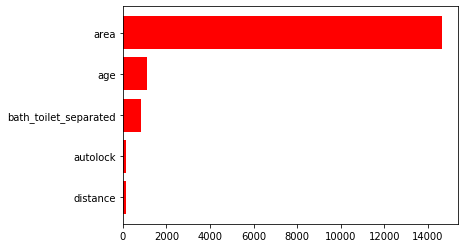

In [17]:
import numpy as np
# 変数重要度（入力変数ごとに決定木回帰の変数重要度の平均を取ったもの）
importances = nbr.booster_.feature_importance(importance_type = "gain")
indices = np.argsort(importances)
plt.barh(np.asarray(feature_name)[indices], importances[indices],
         color="r", align="center")
plt.show()

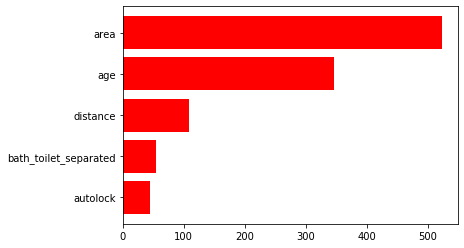

In [18]:
# 変数重要度（決定木のノードにその変数が現れた数の変数重要度として出す。）
importances = nbr.booster_.feature_importance(importance_type = "split")
indices = np.argsort(importances)
plt.barh(np.asarray(feature_name)[indices], importances[indices],
         color="r", align="center")
plt.show()

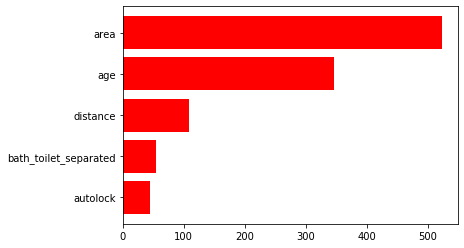

In [19]:
# 変数重要度（feature_importances_は`gain="split"`の結果を返している。）
importances = nbr.feature_importances_
indices = np.argsort(importances)
plt.barh(np.asarray(feature_name)[indices], importances[indices],
         color="r", align="center")
plt.show()